In [ ]:
!pip install pgmpy
!apt install libgraphviz-dev
!pip install pygraphviz
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.5 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 49 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pygraphviz
import seaborn as sns
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator, HillClimbSearch, StructureScore, ExhaustiveSearch, PC, MmhcEstimator, BDeuScore, BicScore, BDsScore
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.inference import VariableElimination
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, log_loss, RocCurveDisplay
import networkx as nx
import optuna
import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data

* person_age $-$	возраст
* person_gender	$-$ пол
* person_education $-$ уровень образования
* person_income	$-$ годовой доход
* person_emp_exp $-$ трудовой стаж
* person_home_ownership $-$	статус домовладельца (аренда, владение, ипотека)
* loan_amnt	$-$ запрошенная сумма кредита
* loan_intent $-$	цель кредита
* loan_int_rate $-$	процентная ставка
* loan_percent_income $-$	сумма кредита в процентах от годового дохода
* cb_person_cred_hist_length $-$	продолжительность кредитной истории
* credit_score $-$	кредитный рейтинг
* previous_loan_defaults_on_file $-$	неуплаты по предыдущим кредитам
* loan_status (**target**)	$-$ статус заявки на кредит (1 $-$ одобрено, 0 $-$ отказано)

In [ ]:
df = pd.read_csv('/content/loan_data.csv')
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

Проверим наличие дубликатов

In [ ]:
df[df.duplicated()]

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status


In [ ]:
pd.set_option('display.max_columns', 40)
%precision %8.8g
# df = df.round(decimals=0)
df.describe().apply(lambda s: s.apply(lambda x: format(x, '.7g')))

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000,45000,45000,45000,45000,45000,45000,45000,45000
mean,27.76418,80319.05,5.410333,9583.158,11.00661,0.1397249,5.867489,632.6088,0.2222222
std,6.045108,80422.5,6.063532,6314.887,2.978808,0.08721231,3.879702,50.43587,0.4157443
min,20,8000,0,500,5.42,0,2,390,0
25%,24,47204,1,5000,8.59,0.07,3,601,0
50%,26,67048,4,8000,11.01,0.12,4,640,0
75%,30,95789.25,8,12237.25,12.99,0.19,8,670,0
max,144,7200766,125,35000,20,0.66,30,850,1


<Axes: xlabel='loan_status', ylabel='count'>

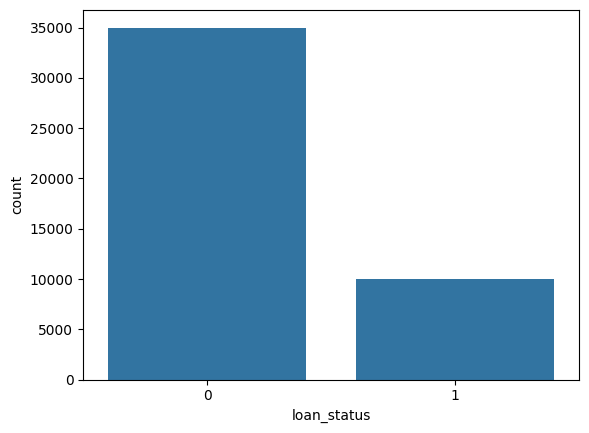

In [ ]:
sns.countplot(data=df, x='loan_status')

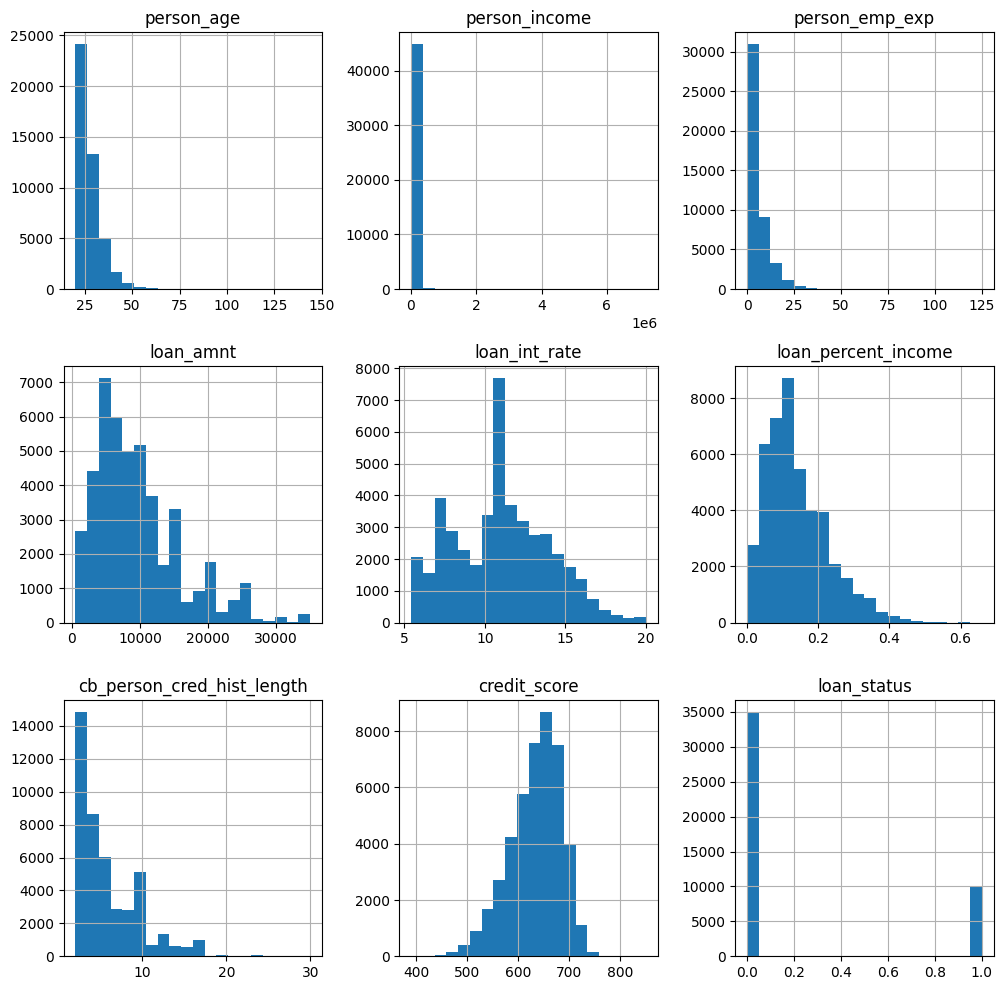

In [ ]:
df.hist(bins = 20, figsize = (12,12))
plt.show()

In [ ]:
cols = ['person_age', 'person_income', 'person_emp_exp']

Q = df[cols].quantile(0.95)

df = df[~(df[cols] > Q).any(axis=1)]

In [ ]:
numerical_col = df.select_dtypes(exclude=np.object_)
categorical_col = df.select_dtypes(exclude=np.number)

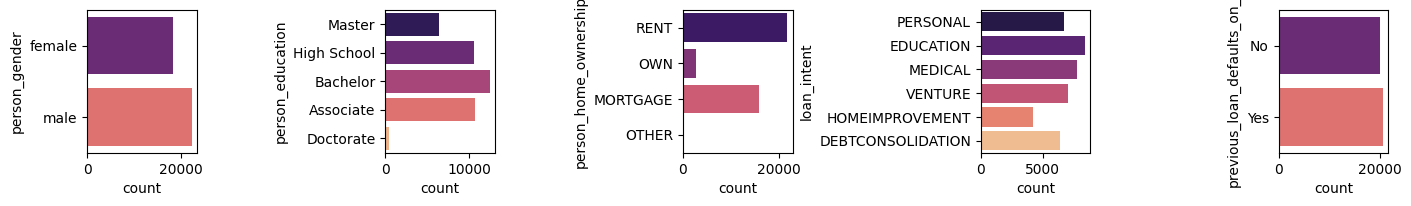

In [ ]:
plt.figure(figsize=(14,2))
for index, column in enumerate(categorical_col):
    plt.subplot(1, 5, index + 1)
    sns.countplot(data=categorical_col, y=column, palette = "magma")
    plt.ylabel(column)
plt.tight_layout(pad = 0.5)
plt.show()

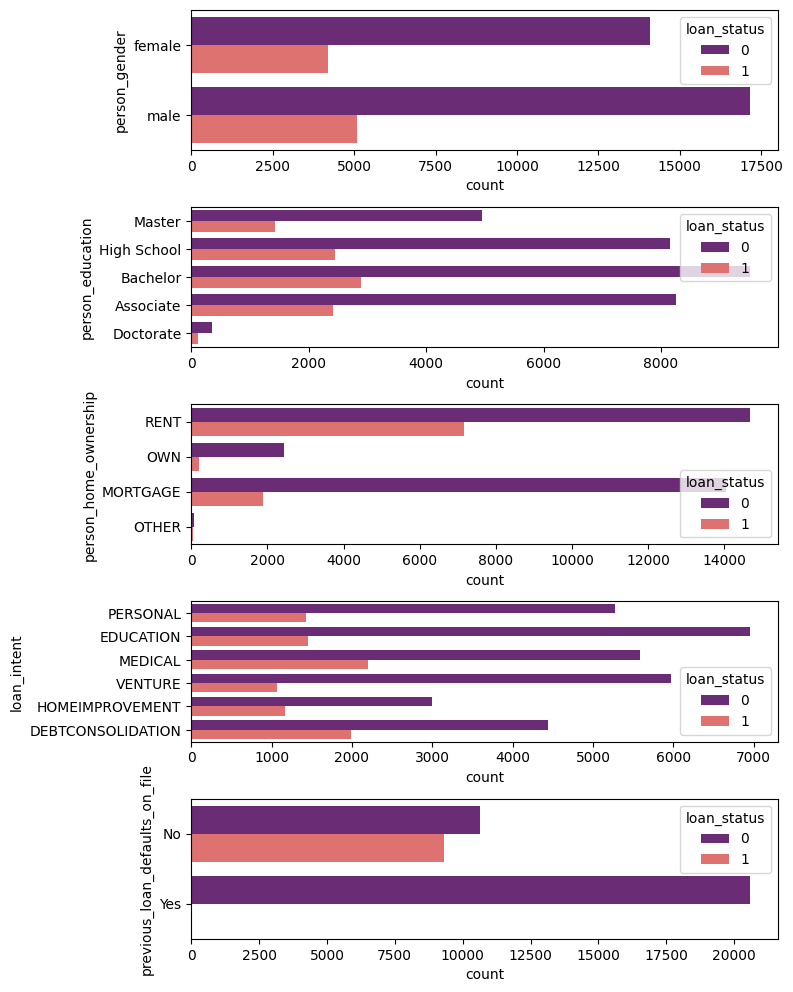

In [ ]:
plt.figure(figsize=(8, 10))
for index in range(len(categorical_col.columns)):
  plt.subplot(5, 1, index + 1)
  sns.countplot(data=categorical_col, y=categorical_col.columns[index], hue=df['loan_status'], palette = "magma")
  plt.ylabel(categorical_col.columns[index])
  plt.subplots_adjust(wspace = 0.3, hspace= 0.3)
plt.tight_layout(pad = 1.0)
plt.show()



*   Людям, снимающим жильё, чаще одобряют кредит, чем домовладельцам и тем, у кого ипотека
*   На лечение, ремонт и консолидацию долга чаще одобряют кредит
*   Людям, имевшим дефолты по кредитам, новый не одобрят



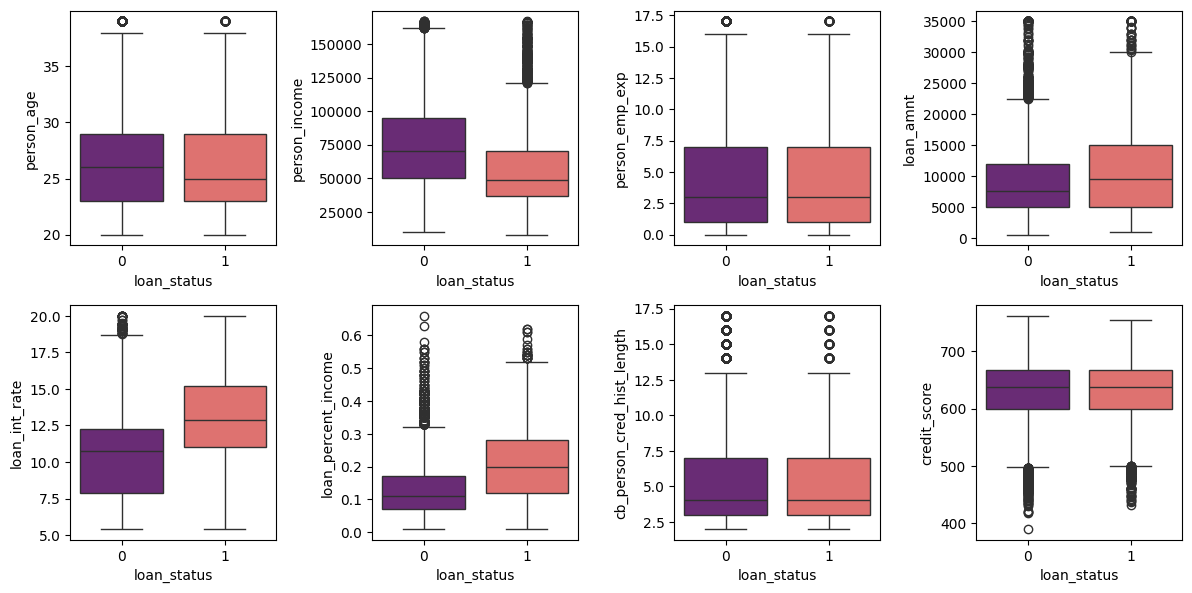

In [ ]:
plt.figure(figsize=(12,6))
for index in range(len(numerical_col.columns)):
  if numerical_col.columns[index] != 'loan_status':
    plt.subplot(2, 4, index + 1)
    sns.boxplot(data=df, y=numerical_col.columns[index],x='loan_status', palette = "magma")
    plt.xlabel('loan_status')
    plt.ylabel(numerical_col.columns[index])
    plt.subplots_adjust(wspace = 0.3, hspace= 0.3)
plt.tight_layout(pad = 1.0)
plt.show()



*   Чаще одобряют людям с более низким доходом
*   Чаще одобряют людям с меньшим трудовым стажем
*   Чаще одобряют кредиты с высокой процентной ставкой
*   Чаще одобряют кредиты, занимающие большую долю от дохода заёмщика



In [ ]:
df['age_group'] = pd.qcut(df['person_age'], 4)
df['income_group'] = pd.qcut(df['person_income'], 4)
df['emp_exp_group'] = pd.qcut(df['person_emp_exp'], 4)
df['loan_amnt_group'] = pd.qcut(df['loan_amnt'], 4)
df['int_rate_group'] = pd.qcut(df['loan_int_rate'], 4)
df['loan_percent_income_group'] = pd.qcut(df['loan_percent_income'], 4)
df['cred_hist_length_group'] = pd.qcut(df['cb_person_cred_hist_length'], 4)
df['credit_score_group'] = pd.qcut(df['credit_score'], 4)

In [ ]:
df.drop(['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score'], axis=1, inplace=True)

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=1488)

In [ ]:
def optuna_optimization(train, test, n_trials=50, direction='maximize'):
    def objective(trial):
        scoring_method_name = trial.suggest_categorical("scoring_method", ["BDeuScore","BDsScore"])
        estimator_equiv_sample_size = trial.suggest_int("estimator_equiv_sample_size", 5, 3000)
        if scoring_method_name == "BDeuScore":
          scoring_method = BDeuScore(train, equivalent_sample_size=estimator_equiv_sample_size)
        elif scoring_method_name == "BDsScore":
          scoring_method = BDsScore(train, equivalent_sample_size=estimator_equiv_sample_size)

        estimator = HillClimbSearch(train)
        model_structure = estimator.estimate(scoring_method=scoring_method)
        estimator_name = trial.suggest_categorical("estimator", ["MaximumLikelihoodEstimator", "BayesianEstimator"])
        model = BayesianNetwork(model_structure.edges())
        model.cpds = []
        if estimator_name == "MaximumLikelihoodEstimator":
          model.fit(data=train, estimator=MaximumLikelihoodEstimator)
        else:
          model_equiv_sample_size = trial.suggest_int("model_equiv_sample_size", 5, 1000)
          model.fit(data=train, estimator=BayesianEstimator,
                    prior_type="BDeu", equivalent_sample_size=model_equiv_sample_size)

        infer = VariableElimination(model)

        pred = []
        for _, row in test.iterrows():
            evidence = row.drop(['loan_status'
            , 'person_gender'
            ]).to_dict()
            predicted = infer.query(variables=['loan_status'], evidence=evidence)
            pred.append(0 if predicted.values[0] >= predicted.values[1] else 1)

        real = test.loan_status

        score = roc_auc_score(real, pred)

        return score

    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_trial.params
    best_score = study.best_trial.value

    print("Best hyperparameters:", best_params)
    print("Best score:", best_score)

    return best_params, best_score

In [ ]:
best_params, best_score = optuna_optimization(
    train=train,
    test=test,
    n_trials=100,
    direction='maximize'
)

[I 2024-12-07 17:56:29,912] A new study created in memory with name: no-name-768f9a8e-1915-4e72-a553-3be3e1bfbb01


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 17:56:47,749] Trial 0 finished with value: 0.8619254515262857 and parameters: {'scoring_method': 'BDsScore', 'estimator_equiv_sample_size': 1467, 'estimator': 'MaximumLikelihoodEstimator'}. Best is trial 0 with value: 0.8619254515262857.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 17:57:07,238] Trial 1 finished with value: 0.8639170221421564 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 2196, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 51}. Best is trial 1 with value: 0.8639170221421564.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 17:57:24,090] Trial 2 finished with value: 0.854949009964554 and parameters: {'scoring_method': 'BDsScore', 'estimator_equiv_sample_size': 2372, 'estimator': 'MaximumLikelihoodEstimator'}. Best is trial 1 with value: 0.8639170221421564.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 17:57:43,393] Trial 3 finished with value: 0.862318301118975 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 2856, 'estimator': 'MaximumLikelihoodEstimator'}. Best is trial 1 with value: 0.8639170221421564.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 17:58:01,791] Trial 4 finished with value: 0.8588964847591909 and parameters: {'scoring_method': 'BDsScore', 'estimator_equiv_sample_size': 937, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 702}. Best is trial 1 with value: 0.8639170221421564.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 17:58:18,650] Trial 5 finished with value: 0.8613846186436465 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 60, 'estimator': 'MaximumLikelihoodEstimator'}. Best is trial 1 with value: 0.8639170221421564.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 17:58:37,490] Trial 6 finished with value: 0.8613183439186994 and parameters: {'scoring_method': 'BDsScore', 'estimator_equiv_sample_size': 1832, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 198}. Best is trial 1 with value: 0.8639170221421564.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 17:58:56,430] Trial 7 finished with value: 0.8598794949978362 and parameters: {'scoring_method': 'BDsScore', 'estimator_equiv_sample_size': 784, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 633}. Best is trial 1 with value: 0.8639170221421564.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 17:59:16,878] Trial 8 finished with value: 0.8659510898582379 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 2383, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 211}. Best is trial 8 with value: 0.8659510898582379.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 17:59:37,636] Trial 9 finished with value: 0.8650905127709622 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 2362, 'estimator': 'MaximumLikelihoodEstimator'}. Best is trial 8 with value: 0.8659510898582379.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 17:59:58,665] Trial 10 finished with value: 0.8627060925624023 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 2995, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 341}. Best is trial 8 with value: 0.8659510898582379.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:00:19,710] Trial 11 finished with value: 0.8656551232783379 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 2481, 'estimator': 'MaximumLikelihoodEstimator'}. Best is trial 8 with value: 0.8659510898582379.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:00:38,505] Trial 12 finished with value: 0.865452754075809 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1669, 'estimator': 'MaximumLikelihoodEstimator'}. Best is trial 8 with value: 0.8659510898582379.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:00:59,601] Trial 13 finished with value: 0.8660497453848711 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 2638, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 930}. Best is trial 13 with value: 0.8660497453848711.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:01:19,266] Trial 14 finished with value: 0.865146671197385 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 2711, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 990}. Best is trial 13 with value: 0.8660497453848711.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:01:39,915] Trial 15 finished with value: 0.8660616341972392 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1801, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 983}. Best is trial 15 with value: 0.8660616341972392.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:01:57,318] Trial 16 finished with value: 0.8649374713317501 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1208, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 962}. Best is trial 15 with value: 0.8660616341972392.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:02:17,520] Trial 17 finished with value: 0.8625649399355583 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1993, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 808}. Best is trial 15 with value: 0.8660616341972392.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:02:33,447] Trial 18 finished with value: 0.8605801999827936 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 385, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 824}. Best is trial 15 with value: 0.8660616341972392.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:02:51,781] Trial 19 finished with value: 0.8674936524549965 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1467, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 511}. Best is trial 19 with value: 0.8674936524549965.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:03:13,292] Trial 20 finished with value: 0.8640020163425777 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1375, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 467}. Best is trial 19 with value: 0.8674936524549965.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:03:31,835] Trial 21 finished with value: 0.8651704488221212 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1994, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 856}. Best is trial 19 with value: 0.8674936524549965.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:03:50,380] Trial 22 finished with value: 0.8667623391821968 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1043, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 553}. Best is trial 19 with value: 0.8674936524549965.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:04:09,798] Trial 23 finished with value: 0.8661602897238726 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1077, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 503}. Best is trial 19 with value: 0.8674936524549965.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:04:28,323] Trial 24 finished with value: 0.8665905782675104 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 967, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 528}. Best is trial 19 with value: 0.8674936524549965.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:04:46,175] Trial 25 finished with value: 0.8624118984963463 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 598, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 474}. Best is trial 19 with value: 0.8674936524549965.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:05:03,817] Trial 26 finished with value: 0.8598301672345195 and parameters: {'scoring_method': 'BDsScore', 'estimator_equiv_sample_size': 652, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 580}. Best is trial 19 with value: 0.8674936524549965.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:05:21,915] Trial 27 finished with value: 0.8665837476044044 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1177, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 367}. Best is trial 19 with value: 0.8674936524549965.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:05:39,965] Trial 28 finished with value: 0.8630445562425128 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 368, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 659}. Best is trial 19 with value: 0.8674936524549965.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:05:57,851] Trial 29 finished with value: 0.8614357189208071 and parameters: {'scoring_method': 'BDsScore', 'estimator_equiv_sample_size': 1476, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 369}. Best is trial 19 with value: 0.8674936524549965.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:06:16,498] Trial 30 finished with value: 0.8665225310287196 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1334, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 721}. Best is trial 19 with value: 0.8674936524549965.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:06:35,075] Trial 31 finished with value: 0.8674936524549965 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1027, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 366}. Best is trial 19 with value: 0.8674936524549965.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:06:53,637] Trial 32 finished with value: 0.8666211865553528 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 934, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 567}. Best is trial 19 with value: 0.8674936524549965.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:07:12,172] Trial 33 finished with value: 0.8668422752333558 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 867, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 416}. Best is trial 19 with value: 0.8674936524549965.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:07:30,577] Trial 34 finished with value: 0.8666211865553528 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 719, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 285}. Best is trial 19 with value: 0.8674936524549965.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:07:49,205] Trial 35 finished with value: 0.8663133311630847 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1553, 'estimator': 'MaximumLikelihoodEstimator'}. Best is trial 19 with value: 0.8674936524549965.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:08:07,850] Trial 36 finished with value: 0.8625598817862963 and parameters: {'scoring_method': 'BDsScore', 'estimator_equiv_sample_size': 408, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 426}. Best is trial 19 with value: 0.8674936524549965.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:08:25,919] Trial 37 finished with value: 0.8658711538070788 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1245, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 259}. Best is trial 19 with value: 0.8674936524549965.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:08:42,013] Trial 38 finished with value: 0.8615376600828586 and parameters: {'scoring_method': 'BDsScore', 'estimator_equiv_sample_size': 837, 'estimator': 'MaximumLikelihoodEstimator'}. Best is trial 19 with value: 0.8674936524549965.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:09:01,944] Trial 39 finished with value: 0.8680157658621616 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1085, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 61}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:09:18,630] Trial 40 finished with value: 0.8617418017992313 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 171, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 43}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:09:36,022] Trial 41 finished with value: 0.8599968699999438 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 553, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 147}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:09:54,772] Trial 42 finished with value: 0.8660922424850819 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1022, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 120}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:10:12,104] Trial 43 finished with value: 0.8659816981460802 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 843, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 401}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:10:30,465] Trial 44 finished with value: 0.8659816981460802 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1150, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 299}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:10:52,102] Trial 45 finished with value: 0.8631907670186187 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1590, 'estimator': 'MaximumLikelihoodEstimator'}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:11:11,526] Trial 46 finished with value: 0.8586022906931351 and parameters: {'scoring_method': 'BDsScore', 'estimator_equiv_sample_size': 1358, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 604}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:11:31,924] Trial 47 finished with value: 0.8655632984148106 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1718, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 13}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:11:50,324] Trial 48 finished with value: 0.8663320506385589 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 895, 'estimator': 'MaximumLikelihoodEstimator'}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:12:09,619] Trial 49 finished with value: 0.8660310259093968 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1087, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 691}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:12:27,914] Trial 50 finished with value: 0.8659510898582379 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1293, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 197}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:12:47,075] Trial 51 finished with value: 0.8648388158051168 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 951, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 554}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:13:05,641] Trial 52 finished with value: 0.864850704617485 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1455, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 430}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:13:24,486] Trial 53 finished with value: 0.865379648687756 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 793, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 625}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:13:43,967] Trial 54 finished with value: 0.8664919227408772 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1053, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 458}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:14:01,559] Trial 55 finished with value: 0.867524260742839 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 743, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 531}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:14:20,470] Trial 56 finished with value: 0.8622894653449766 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 519, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 735}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:14:37,907] Trial 57 finished with value: 0.8677640688963161 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 712, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 515}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:14:56,610] Trial 58 finished with value: 0.8672725637769936 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 704, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 324}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:15:14,318] Trial 59 finished with value: 0.861415226931489 and parameters: {'scoring_method': 'BDsScore', 'estimator_equiv_sample_size': 179, 'estimator': 'MaximumLikelihoodEstimator'}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:15:32,325] Trial 60 finished with value: 0.8677640688963161 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 742, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 503}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:15:50,938] Trial 61 finished with value: 0.8664307061651922 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 700, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 352}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:16:09,194] Trial 62 finished with value: 0.8619016739015495 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 486, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 504}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:16:26,571] Trial 63 finished with value: 0.8677640688963161 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 718, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 514}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:16:45,440] Trial 64 finished with value: 0.8653609292122819 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 609, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 507}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:17:04,711] Trial 65 finished with value: 0.8656262875043393 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 760, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 592}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:17:22,285] Trial 66 finished with value: 0.8623200736328189 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 441, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 466}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:17:40,232] Trial 67 finished with value: 0.862769081651931 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 302, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 541}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:18:01,859] Trial 68 finished with value: 0.8662521145873998 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1926, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 665}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:18:21,077] Trial 69 finished with value: 0.8658711538070788 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1126, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 533}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:18:41,261] Trial 70 finished with value: 0.8668116669455134 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 646, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 481}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:18:59,937] Trial 71 finished with value: 0.865969809333712 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 754, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 382}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:19:18,569] Trial 72 finished with value: 0.8671432999625179 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 958, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 315}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:19:36,488] Trial 73 finished with value: 0.8637520918905762 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 300, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 436}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:19:54,491] Trial 74 finished with value: 0.8657418899926032 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 658, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 98}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:20:15,263] Trial 75 finished with value: 0.863068333867249 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 2205, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 212}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:20:32,398] Trial 76 finished with value: 0.8610104885264315 and parameters: {'scoring_method': 'BDsScore', 'estimator_equiv_sample_size': 560, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 510}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:20:51,356] Trial 77 finished with value: 0.867973268761951 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 823, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 627}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:21:10,355] Trial 78 finished with value: 0.8636041086006263 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 829, 'estimator': 'MaximumLikelihoodEstimator'}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:21:29,369] Trial 79 finished with value: 0.8669834278601997 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1277, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 639}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:21:49,079] Trial 80 finished with value: 0.8624493374472947 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 997, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 770}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:22:06,972] Trial 81 finished with value: 0.8669409307599891 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 900, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 578}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:22:24,483] Trial 82 finished with value: 0.8677640688963161 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 770, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 475}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:22:43,761] Trial 83 finished with value: 0.8666517948431953 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 780, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 614}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:23:01,386] Trial 84 finished with value: 0.8674936524549965 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 880, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 559}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:23:21,314] Trial 85 finished with value: 0.8670633639113587 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1142, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 481}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:23:40,281] Trial 86 finished with value: 0.8672538443015193 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1189, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 449}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:23:57,131] Trial 87 finished with value: 0.8622520263940281 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 604, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 402}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:24:16,173] Trial 88 finished with value: 0.861643146272598 and parameters: {'scoring_method': 'BDsScore', 'estimator_equiv_sample_size': 1003, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 528}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:24:31,945] Trial 89 finished with value: 0.8617724100870737 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 472, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 668}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:24:49,736] Trial 90 finished with value: 0.8646227852763759 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1407, 'estimator': 'MaximumLikelihoodEstimator'}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:25:08,720] Trial 91 finished with value: 0.8654102569755986 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 885, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 563}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:25:26,905] Trial 92 finished with value: 0.8671314111501497 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 694, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 578}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:25:44,795] Trial 93 finished with value: 0.8655463514531803 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 825, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 525}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:26:04,692] Trial 94 finished with value: 0.8664000978773498 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 740, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 483}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:26:22,529] Trial 95 finished with value: 0.8666211865553528 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 918, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 637}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:26:41,050] Trial 96 finished with value: 0.8671314111501497 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1089, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 601}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:26:59,939] Trial 97 finished with value: 0.8569797920452172 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 558, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 491}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:27:18,889] Trial 98 finished with value: 0.8663133311630847 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1020, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 543}. Best is trial 39 with value: 0.8680157658621616.


  0%|          | 0/1000000 [00:00<?, ?it/s]

[I 2024-12-07 18:27:38,547] Trial 99 finished with value: 0.8664000978773498 and parameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1244, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 888}. Best is trial 39 with value: 0.8680157658621616.


Best hyperparameters: {'scoring_method': 'BDeuScore', 'estimator_equiv_sample_size': 1085, 'estimator': 'BayesianEstimator', 'model_equiv_sample_size': 61}
Best score: 0.8680157658621616


In [ ]:
best_params

{'scoring_method': 'BDeuScore',
 'estimator_equiv_sample_size': 1085,
 'estimator': 'BayesianEstimator',
 'model_equiv_sample_size': 61}

In [ ]:
estimator = HillClimbSearch(train)
model_structure = estimator.estimate(scoring_method=BDeuScore(train, equivalent_sample_size=1085))

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [ ]:
model_structure.edges()

OutEdgeView([('person_education', 'credit_score_group'), ('person_education', 'age_group'), ('person_education', 'emp_exp_group'), ('person_education', 'loan_status'), ('person_home_ownership', 'loan_amnt_group'), ('person_home_ownership', 'previous_loan_defaults_on_file'), ('person_home_ownership', 'int_rate_group'), ('person_home_ownership', 'cred_hist_length_group'), ('person_home_ownership', 'loan_percent_income_group'), ('loan_intent', 'person_home_ownership'), ('loan_intent', 'income_group'), ('previous_loan_defaults_on_file', 'loan_amnt_group'), ('previous_loan_defaults_on_file', 'cred_hist_length_group'), ('loan_status', 'loan_percent_income_group'), ('loan_status', 'int_rate_group'), ('loan_status', 'person_home_ownership'), ('loan_status', 'income_group'), ('loan_status', 'loan_amnt_group'), ('loan_status', 'loan_intent'), ('loan_status', 'previous_loan_defaults_on_file'), ('loan_status', 'cred_hist_length_group'), ('loan_status', 'age_group'), ('age_group', 'cred_hist_length

In [ ]:
model_graphviz = model_structure.to_graphviz()

model_graphviz.draw("sachs.png", prog="dot")

In [ ]:
model = BayesianNetwork(model_structure.edges())
model.cpds = []
model.fit(data=train, estimator=BayesianEstimator, prior_type="BDeu", equivalent_sample_size=61)

In [ ]:
def print_full(cpd):
    backup = TabularCPD._truncate_strtable
    TabularCPD._truncate_strtable = lambda self, x: x
    print(cpd)
    TabularCPD._truncate_strtable = backup

for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print_full(cpd)
    print()

CPT of person_education:
+-------------------------------+-----------+
| person_education(Associate)   | 0.262654  |
+-------------------------------+-----------+
| person_education(Bachelor)    | 0.306377  |
+-------------------------------+-----------+
| person_education(Doctorate)   | 0.0115528 |
+-------------------------------+-----------+
| person_education(High School) | 0.261791  |
+-------------------------------+-----------+
| person_education(Master)      | 0.157625  |
+-------------------------------+-----------+

CPT of credit_score_group:
+--------------------------------------+-----------------------------+----------------------------+-----------------------------+-------------------------------+--------------------------+
| person_education                     | person_education(Associate) | person_education(Bachelor) | person_education(Doctorate) | person_education(High School) | person_education(Master) |
+--------------------------------------+-----------------------

In [ ]:
infer = VariableElimination(model)

In [ ]:
print(infer.query(variables=['loan_status']))

+----------------+--------------------+
| loan_status    |   phi(loan_status) |
+================+====================+
| loan_status(0) |             0.7697 |
+----------------+--------------------+
| loan_status(1) |             0.2303 |
+----------------+--------------------+


In [ ]:
pred = []
for _, row in test.iterrows():
    evidence = row.drop(['loan_status'
    , 'person_gender'
    ]).to_dict()
    predicted = infer.query(variables=['loan_status'], evidence=evidence)
    pred.append(0 if predicted.values[0] >= predicted.values[1] else 1)

In [ ]:
real = test.loan_status

In [ ]:
print(classification_report(real, pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      6255
           1       0.80      0.80      0.80      1849

    accuracy                           0.91      8104
   macro avg       0.87      0.87      0.87      8104
weighted avg       0.91      0.91      0.91      8104



Text(0.5, 36.72222222222221, 'Predicted Label')

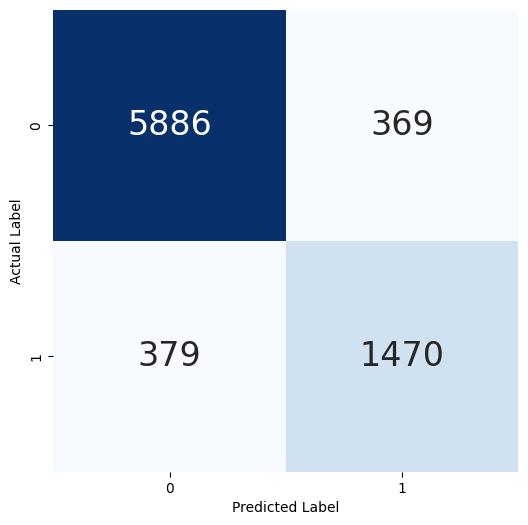

In [ ]:
plt.figure(figsize=(6, 6))

sns.heatmap(confusion_matrix(real, pred),annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

AUC-ROC: 0.8680157658621616


<Figure size 800x600 with 0 Axes>

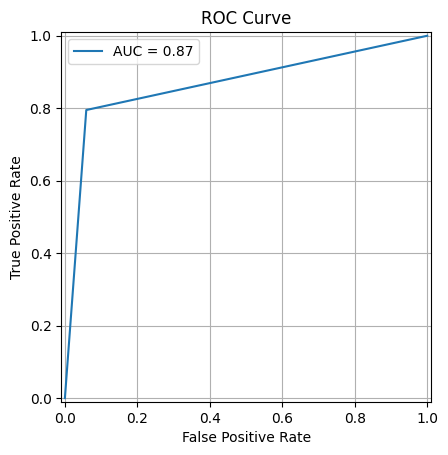

In [ ]:
# AUC-ROC score
auc = roc_auc_score(real, pred)
print(f"AUC-ROC: {auc}")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(real, pred)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
display.plot()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


In [ ]:
logloss = log_loss(real, pred)
print(f"Log Loss: {logloss}")

Log Loss: 3.326832765925423
